In [ ]:
from google.colab import drive
import random
import numpy as np
import time
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.spatial import distance_matrix
from progressbar import progressbar
plt.style.use('ggplot')
plt.rcParams["figure.figsize"]=10,5
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
text_size = 25
line_width = 2.5

drive.mount('/drive')
path = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 3"
path_figures = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/figures"

def read_files_dir(path):
  '''function for reading and combining files in a directory'''
  os.chdir(path)
  file_list = os.listdir()
  df_1 = pd.DataFrame()
  for i in file_list:
    if i[len(i)-3:len(i)] != "csv":
      continue
    print(i)
    data = pd.read_csv(i)
    data["file"] = i
    df_1 = pd.concat([df_1, data])
  return df_1

Mounted at /drive


## Read file function

In [ ]:
def get_distance_matrix(df):
    matrix = np.zeros((len(df), len(df)))
    for index1, row1 in df.iterrows():
        for index2, row2 in df.iterrows():
            diff_x = row1["x"] - row2["x"]
            diff_y = row1["y"] - row2["y"]
            distance = (diff_x**2 + diff_y**2)**0.5
            matrix[index1][index2] = distance
    return matrix

def read_tsp(path):
    '''reads tsp file, 
    returns dataframe with city number and coordinates,
    returns dataframe with distances between cities'''
    file = open(path, "r")
    f = file.readlines()
    new_list = []
    for line in f:
        new_list.append(line[:-1])
    new_list = new_list[:-1]
    split_list = [item.split() for item in new_list]
    names = [int(item[0])-1 for item in split_list]
    coords = [item[1:3] for item in split_list]
    df = pd.DataFrame(coords, columns=['x', 'y'], index=names)
    df = df.astype(float)
    distances = get_distance_matrix(df)
    return df, distances
     
def read_optimal_route(path):    
    with open(path, "r") as f:
        lines = f.read()
    list_ = lines.split("\n")
    list_ = [int(x)-1 for x in list_]
    return list_

# Plotting function

In [ ]:
def plot_path(route, df, connect = True):
    route_copy = route[:]
    if connect == True:
        route_copy.append(route_copy[0])
    x_list = []
    y_list = []
    cities = []
    for city in route_copy:
        x_list.append(int(df.iloc[city]["x"]))
        y_list.append(int(df.iloc[city]["y"]))
        cities.append(city)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.plot(x_list, y_list)

## Distance function

In [ ]:
def get_distance(dist_mat, route, connected = True):
    '''route supplied must have cities that start numbering from 0'''
    distance = 0
    copy_route = route[:]
    if connected == True:
        copy_route.append(route[0])
    for i in range(len(copy_route)-1):
        distance += dist_mat[copy_route[i]][copy_route[i+1]]
    return distance

## Mutation functions

### Change location of one node

In [ ]:
def move_node(route):
     new_route = route[:]
     n, to_position = random.sample(range(0, len(new_route)), 2)
     item = new_route[n] # get the item
     new_route.remove(item) # remove the item from the list
     new_route.insert(to_position, item) # move item to the desired position
     return new_route


### Swap location of two nodes

In [ ]:
def swap_nodes(route):
     new_route = route[:]
     # swap two cities
     pos_1, pos_2 = random.sample(range(0, len(new_route)), 2)
     val_1 = new_route[pos_1]
     val_2 = new_route[pos_2]
     new_route[pos_1] = val_2
     new_route[pos_2] = val_1
     return new_route

### Reverse

In [ ]:
def reverse_nodes(route):
    copy_route = route[:]
    pos_1, pos_2 = random.sample(range(0, len(copy_route)), 2)
    if pos_2 < pos_1:
        pos_1, pos_2 = pos_2, pos_1
    reversed_ = copy_route[pos_1:pos_2][::-1]
    new_route = copy_route[0:pos_1] + reversed_ + copy_route[pos_2:]
    return new_route

### Shuffle

In [ ]:
def shuffle_nodes(route):
    copy_route = route[:]
    pos_1, pos_2 = random.sample(range(0, len(copy_route)), 2)
    if pos_2 < pos_1:
        pos_1, pos_2 = pos_2, pos_1
    to_shuffle = copy_route[pos_1:pos_2][::-1]
    random.shuffle(to_shuffle)
    new_route = copy_route[0:pos_1] + to_shuffle + copy_route[pos_2:]
    return new_route

# Simulated annealing function

In [ ]:
def SA(update_func, route_0, dist_mat, t_0 = 100, t_end = 0.1, alpha = 0.95, beta = 1.2, chain = 100, sch_method = "geometric", adaptive = False, stop_criteria = 1000):
    t_current = t_0
    t_list = [t_current]
    found_distances = [get_distance(dist_mat, route_0)]
    methods = []
    best_route = route_0[:]
    global_best_route = route_0[:]
    k = 0
    non_improvement_counter = 0
    all_distances = [get_distance(dist_mat, route_0)]
    outter_loop = 0
    for stop in progressbar(range(stop_criteria)):
        k += 1
        for i in range(chain):
            if adaptive == False:
                new_route = update_func(best_route)
                new_distance = get_distance(dist_mat, new_route)
                diff_distance = get_distance(dist_mat, best_route) - new_distance
                all_distances.append(new_distance)
            else:
                new_routes = [swap_nodes(best_route), move_node(best_route), reverse_nodes(best_route), shuffle_nodes(best_route)]
                new_distances = [get_distance(dist_mat, new_routes[0]), get_distance(dist_mat, new_routes[1]), get_distance(dist_mat, new_routes[2]), get_distance(dist_mat, new_routes[3])]
                min_new_distance = np.min(new_distances)
                chosen_method = new_distances.index(min_new_distance)
                new_route = new_routes[chosen_method]
                all_distances.append(min_new_distance)
                diff_distance = get_distance(dist_mat, best_route) - min_new_distance
            if diff_distance > 0: # accept new solution as best solution if better
                best_route = new_route
                methods.append(chosen_method)
            else:
                p = np.e**(diff_distance/t_current)
                if random.uniform(0, 1) < p:
                    best_route = new_route
                    methods.append(chosen_method)
        best_distance = get_distance(dist_mat, best_route)
        found_distances.append(best_distance)
        # 1, with aplha = 0.99
        if sch_method == "geometric":
            t_current = t_current * alpha
        # 2, with alpha = 1
        elif sch_method == "linear":
            t_current = t_current - t_0/stop_criteria
        elif sch_method == "logarithmic":
            # alpha smaller than 1 can speed up the process
            t_current = 0.5*t_0/np.log(k+1)
        elif sch_method == "multiplicative_l":
            t_current = t_0/(1+alpha*k)
        elif sch_method == "multiplicative_q":
            t_current = t_0/(1+alpha*k**2)
        elif sch_method == "lundy":
            # spend less time in the high temperature phases and more time in the low temperature phases
            t_current = t_current/(1+alpha*t_current)
        # 3
        elif sch_method == "adaptive":
            t_current = (1+(min(found_distances)- best_distance)/best_distance)*t_current
        elif sch_method == "addative":
            t_current = t_end+(t_0-t_end)*(chain-k)/chain
        else:
            print("Error in the cooling method")
            return
        t_list.append(t_current)
         # check if the distance imporved since last time
        if best_distance < found_distances[-2]:
            non_improvement_counter = 0
        else:
            non_improvement_counter += 1
        #if non_improvement_counter == 100:
        #    break
        #print(t_current)
        #print(np.min(all_distances))
        #print(non_improvement_counter)
    return found_distances, all_distances, t_list, methods, best_route

# Running the simulations

In [ ]:
chains = [10, 100, 250, 500, 750, 1000, 2000]
sch_methods = ["linear", "adaptive", "geometric"][1:3]
t_0 = 45
sims = 5
stop_criteria = 1000
save_path_bp = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/280/bp"
save_path_cm = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/280/cm"

df_file, dist_mat = read_tsp("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/a280.tsp.txt")
for sch_method in sch_methods:
  for chain in chains:
    df1 = pd.DataFrame()
    for sim in range(sims, sims*2):    
        print(f"sim:{sim}, chain:{chain}, method:{sch_method}")    
        random_route = [int(x) for x in random.sample(df_file.index.tolist(), k = len(df_file.index))]
        found_distances, all_distances, t_list, methods, best_route = SA(swap_nodes, random_route, dist_mat, chain = chain, alpha = 0.99, t_0 = t_0, t_end = 0.001, stop_criteria=stop_criteria, sch_method=sch_method, adaptive=True)
        df_dict1 = {
          "order": range(stop_criteria+1),
          "simulation" : sim,
          "sch_method" : sch_method,
          "chain lenght" : chain,
          "found_distances" : found_distances,
        }
        df_in1 = pd.DataFrame(df_dict1)
        df1 = df1.append(df_in1)
        now = datetime.now()
        df2 = pd.DataFrame()
        df_dict2 = {
          "simulation" : sim,
          "candide method" : methods
        }
        df_in2 = pd.DataFrame(df_dict2)
        df2 = df2.append(df_in2)
    df1.to_csv(f"{save_path_bp}/bp_2,s={sims},c={chain},sch={sch_method},date={now}.csv", index=False)
    df2.to_csv(f"{save_path_cm}/cm_2,s={sims},c={chain},sch={sch_method},date={now}.csv", index=False)


# Exploratory analysis

## Trying temperatures

In [ ]:
t_list = [70, 45, 15]
chain = 500
sch_method = "geometric"
sims = 10
stop_criteria = 1000
save_path = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/explorative 51 cities/temperature"

df_file, dist_mat = read_tsp("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/eil51.tsp.txt")
for t in t_list:
  df1 = pd.DataFrame()
  for sim in range(sims, sims*2):    
      print(f"sim:{sim}, chain:{chain}, t:{t}, method:{sch_method}")    
      random_route = [int(x) for x in random.sample(df_file.index.tolist(), k = len(df_file.index))]
      found_distances, all_distances, t_list, methods, best_route = SA(move_node, random_route, dist_mat, chain = chain, alpha = 0.99, t_0 = t, t_end = 0.001, stop_criteria=stop_criteria, sch_method=sch_method, adaptive=False)
      df_dict1 = {
        "order": range(stop_criteria+1),
        "temperatur": t,
        "simulation" : sim,
        "sch_method" : sch_method,
        "chain lenght" : chain,
        "found_distances" : found_distances,
      }
      df_in1 = pd.DataFrame(df_dict1)
      df1 = df1.append(df_in1)
      now = datetime.now()
  df1.to_csv(f"{save_path}/bp_2,s={sims},c={chain},t = {t}, sch={sch_method},date={now}.csv", index=False)


### Extracting the results

In [ ]:
data = read_files_dir("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/explorative 51 cities/temperature")
data.head()

bp_2,s=10,c=500,t = 75, sch=geometric,date=2020-12-07 11:35:37.058438.csv
bp_2,s=10,c=500,t = 45, sch=geometric,date=2020-12-07 11:42:24.843366.csv
bp_2,s=10,c=500,t = 15, sch=geometric,date=2020-12-07 13:57:27.632487.csv


,order,temperatur,simulation,sch_method,chain lenght,found_distances,file
0,0,75,10,geometric,500,1621.065901,"bp_2,s=10,c=500,t = 75, sch=geometric,date=202..."
1,1,75,10,geometric,500,1473.085426,"bp_2,s=10,c=500,t = 75, sch=geometric,date=202..."
2,2,75,10,geometric,500,1589.746539,"bp_2,s=10,c=500,t = 75, sch=geometric,date=202..."
3,3,75,10,geometric,500,1615.804107,"bp_2,s=10,c=500,t = 75, sch=geometric,date=202..."
4,4,75,10,geometric,500,1480.609764,"bp_2,s=10,c=500,t = 75, sch=geometric,date=202..."


#### Min distance

In [ ]:
data.groupby(["temperatur"])["found_distances"].min()

temperatur
15    430.244022
45    436.446078
75    430.244022
Name: found_distances, dtype: float64

In [ ]:
data_t_test = data.groupby(["temperatur", "simulation"])["found_distances"].min().reset_index()
data_t_test.head()

,temperatur,simulation,found_distances
0,15,10,437.622361
1,15,11,443.280426
2,15,12,433.988164
3,15,13,430.244022
4,15,14,432.842894


In [ ]:
st.ttest_ind(data_t_test[data_t_test.temperatur == 15].found_distances, data_t_test[data_t_test.temperatur == 45].found_distances, equal_var=False)

Ttest_indResult(statistic=-1.0279106605561266, pvalue=0.31874041441778267)

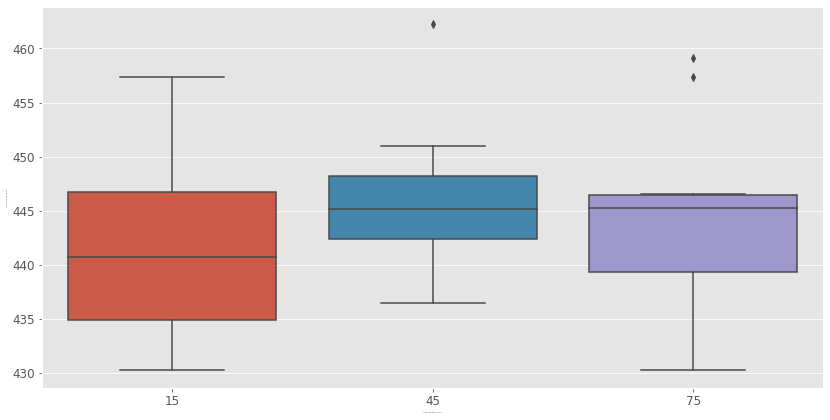

In [ ]:
plt.figure(figsize=(14,7))
sns.boxplot(data = data_t_test,
            y = "found_distances",
            x = "temperatur")
plt.xlabel("Initial temperature", size = text_size)
plt.ylabel("Minimum distance",size = text_size)
plt.savefig(path_figures+"/box_plot_temperatures.pdf", bpi = 3000)

In [ ]:
# variance of the data
data_t_test.groupby("temperatur")["found_distances"].var()

temperatur
15    90.108390
45    49.514014
75    76.901222
Name: found_distances, dtype: float64

## Trying mutation mechanisms

In [ ]:
t_0 = 45
chain = 500
mutation_methods= [move_node, swap_nodes, reverse_nodes, shuffle_nodes]
methods = ["move", "swap", "reverse", "shuffle"]
sims = 10
stop_criteria = 1000
save_path = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/explorative 51 cities/mutation experiment"

df_file, dist_mat = read_tsp("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/eil51.tsp.txt")
i = 0
for m_method in mutation_methods:
  df1 = pd.DataFrame()
  for sim in range(sims, sims*2):    
    print(f"sim:{sim}, chain:{chain}, t:{t}, method:{methods[i]}")    
    random_route = [int(x) for x in random.sample(df_file.index.tolist(), k = len(df_file.index))]
    found_distances, all_distances, t_list, methods_, best_route = SA(m_method, random_route, dist_mat, chain = chain, alpha = 0.99, t_0 = t_0, t_end = 0.001, stop_criteria=stop_criteria, sch_method=sch_method, adaptive=False)
    df_dict1 = {
      "order": range(stop_criteria+1),
      "temperature": t,
      "mutation_method": methods[i],
      "simulation" : sim,
      "sch_method" : sch_method,
      "chain lenght" : chain,
      "found_distances" : found_distances,
    }
    df_in1 = pd.DataFrame(df_dict1)
    df1 = df1.append(df_in1)
    now = datetime.now()
  df1.to_csv(f"{save_path}/bp_2,s={sims},c={chain},mutation_method = {methods[i]}, sch={sch_method},date={now}.csv", index=False)
  i += 1


### Extracting the results

In [ ]:
data = read_files_dir("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/explorative 51 cities/mutation experiment")
data.head()
data_combination_1 = pd.read_csv("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/51/bp/bp_2,s=5,c=500,sch=geometric,date=2020-12-06 13:52:47.751115.csv")
data_combination_2 = pd.read_csv("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/51/bp/bp,s=5,c=500,sch=geometric,date=2020-12-06 13:47:32.185431.csv")
data_combination = data_combination_1.append(data_combination_2)
data_combination["mutation_method"] = "hybrid"


bp_2,s=10,c=500,mutation_method = move, sch=geometric,date=2020-12-07 12:02:45.694387.csv
bp_2,s=10,c=500,mutation_method = swap, sch=geometric,date=2020-12-07 12:09:12.960602.csv
bp_2,s=10,c=500,mutation_method = reverse, sch=geometric,date=2020-12-07 12:15:45.305217.csv
bp_2,s=10,c=500,mutation_method = shuffle, sch=geometric,date=2020-12-07 12:23:21.085237.csv


In [ ]:
data.groupby(["mutation_method"])["found_distances"].min()

mutation_method
move       432.098347
reverse    435.654387
shuffle    540.850870
swap       456.374905
Name: found_distances, dtype: float64

In [ ]:
data_box_plot_1 = data.groupby(["mutation_method", "simulation"])["found_distances"].min().reset_index()
data_box_plot_2 = data_combination.groupby(["mutation_method", "simulation"])["found_distances"].min().reset_index()
data_box_plot = data_box_plot_1.append(data_box_plot_2)
data_box_plot.head()

,mutation_method,simulation,found_distances
0,move,10,437.539973
1,move,11,472.178344
2,move,12,433.973516
3,move,13,432.098347
4,move,14,458.043577


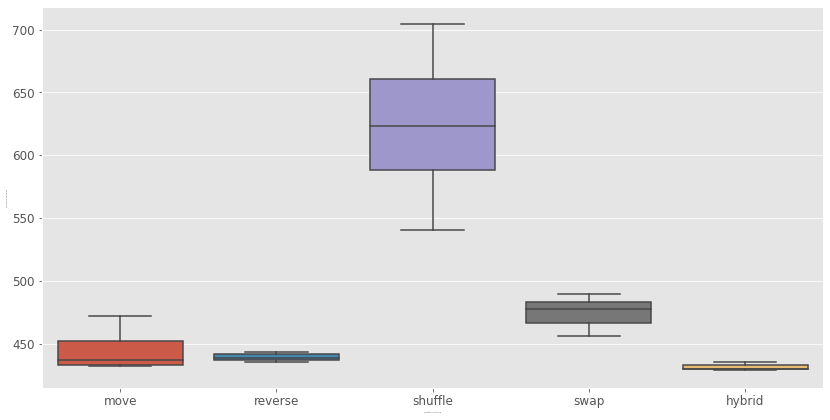

In [ ]:
plt.figure(figsize=(14,7))
sns.boxplot(data = data_box_plot,
            y = "found_distances",
            x = "mutation_method")
plt.ylabel("Minimum distance", size = text_size)
plt.xlabel("Mutation method", size = text_size)
plt.savefig(path_figures+"/box_plot_mutation.pdf", bpi = 3000)

#### t-test

In [ ]:
st.ttest_ind(data_box_plot[data_box_plot.mutation_method == "hybrid"].found_distances, data_box_plot[data_box_plot.mutation_method == "reverse"].found_distances, equal_var=False)

Ttest_indResult(statistic=-6.64616955194356, pvalue=3.4405510521054345e-06)

# Analysis for 51 and 280 cities

In [ ]:
# read data
data_51 = read_files_dir("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/51/bp")
data_208 = read_files_dir("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/280/bp")
data_51["cities"] = 51
data_208["cities"] = 280
data_51 = data_51[(data_51["order"] != 0)]
data_208 = data_208[(data_208["order"] != 0)]
combined = data_51.append(data_208)

In [ ]:
combined.head()

,order,simulation,sch_method,chain lenght,found_distances,file,cities
1,1,5,adaptive,10,1337.592619,"bp_2,s=5,c=10,sch=adaptive,date=2020-12-06 12:...",51
2,2,5,adaptive,10,1325.447195,"bp_2,s=5,c=10,sch=adaptive,date=2020-12-06 12:...",51
3,3,5,adaptive,10,1287.045002,"bp_2,s=5,c=10,sch=adaptive,date=2020-12-06 12:...",51
4,4,5,adaptive,10,1200.608201,"bp_2,s=5,c=10,sch=adaptive,date=2020-12-06 12:...",51
5,5,5,adaptive,10,1210.192512,"bp_2,s=5,c=10,sch=adaptive,date=2020-12-06 12:...",51


## Convergence plots

<Figure size 842.4x595.44 with 0 Axes>

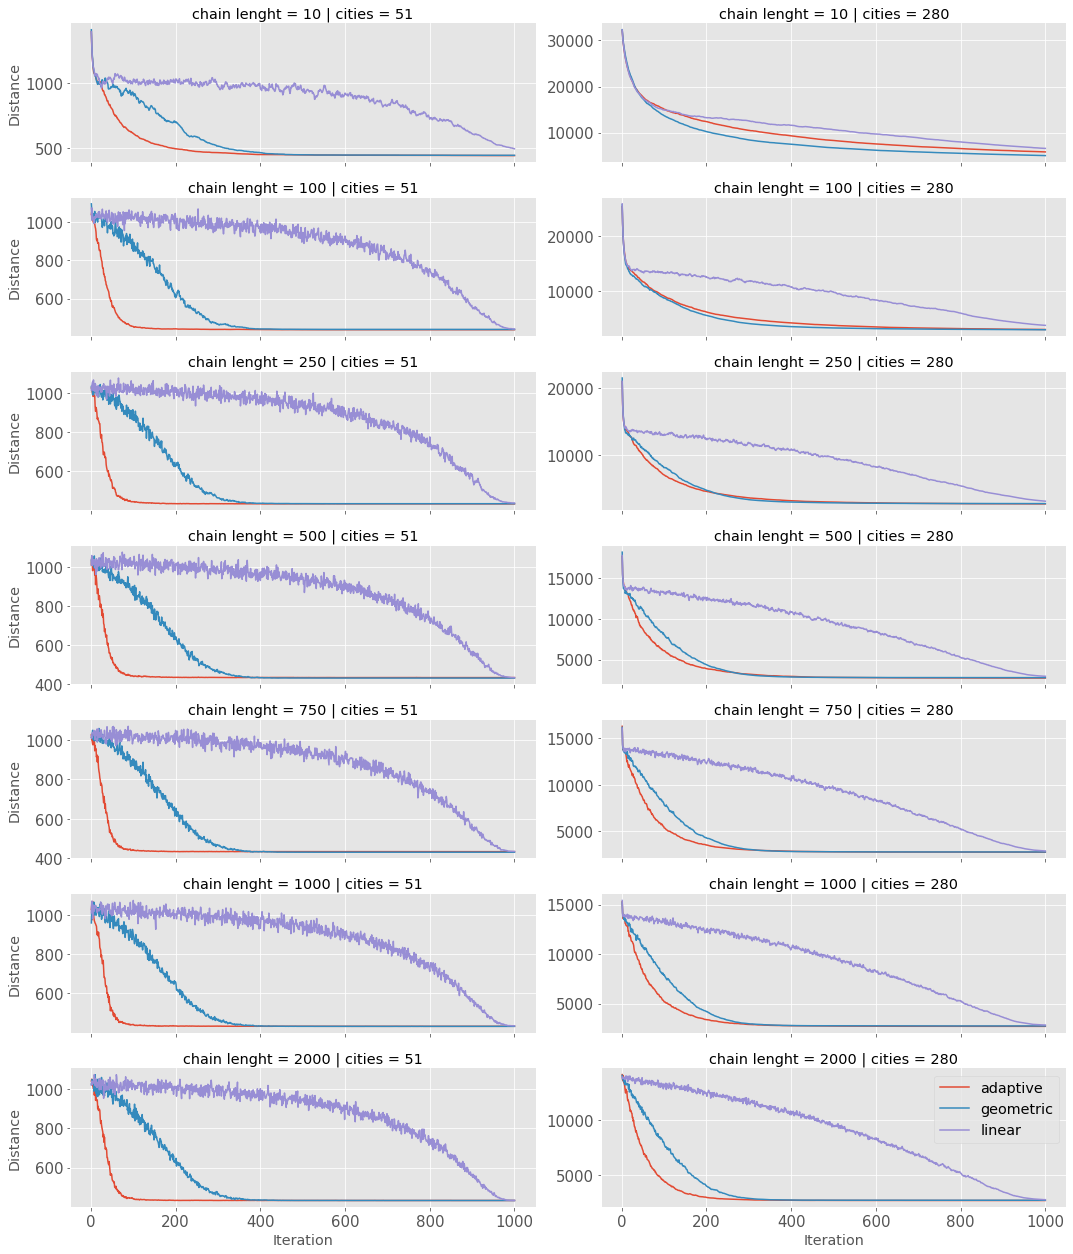

In [ ]:
plt.figure(figsize=(11.7,8.27))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
text_size = 2
line_width = 2.5
g = sns.FacetGrid(combined, row="chain lenght", col = "cities", sharey=False, sharex=True, hue = "sch_method", height=2.5, aspect=3)
g.map(sns.lineplot, "order", "found_distances", ci = None)
g.set_axis_labels("Iteration", "Distance")
#g.add_legend()
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize='x-large')
    # This only works for the left ylabels
    ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
    ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
plt.legend(fontsize='x-large', title_fontsize='40')
plt.savefig(path_figures+"/convergence.pdf", bpi = 3000)
plt.show()

In [ ]:
# find minimum values

combined.head()
combined.groupby("cities")["found_distances"].min().to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &  found\\_distances \\\\\ncities &                  \\\\\n\\midrule\n51     &       428.871756 \\\\\n280    &      2600.728382 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Chain lenght comparison plot

<Figure size 1008x504 with 0 Axes>

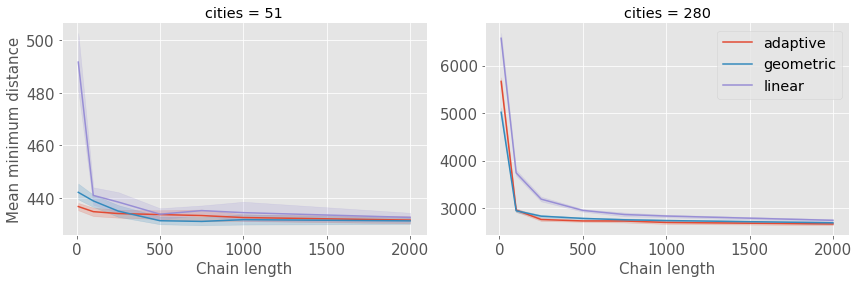

In [ ]:
# extract minimal value for each chain lenght and simulation
plt.figure(figsize=(14,7))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
for_plot = combined.groupby(["chain lenght", "simulation", "sch_method", "cities"])["found_distances"].min().reset_index()

# plot y = minimal length, x = chain_lenght, color = cooling method
g = sns.FacetGrid(for_plot, col = "cities", sharey=False, sharex=True, hue = "sch_method", height=4, aspect=1.5)
g.map(sns.lineplot, "chain lenght", "found_distances", ci = 95, estimator = "mean")
plt.legend(fontsize='x-large', title_fontsize='40')
g.set_axis_labels("Chain length", "Mean minimum distance")
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize='x-large')
    # This only works for the left ylabels
    ax.set_ylabel(ax.get_ylabel(), fontsize=15)
    ax.set_xlabel(ax.get_xlabel(), fontsize=15)
plt.savefig(path_figures+"/chain_and_min.pdf", bpi = 3000)

## Checking progress of methods over the itteration

In [ ]:
# 280 cities
path_280 = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/280/cm_updated/geometric"
data = read_files_dir(path_280)

cumsum_data = pd.get_dummies(data["candide method"]).cumsum()
cumsum_data['progress'] = cumsum_data.index + 1
cumsum_data['Swap'] = cumsum_data[0]/cumsum_data['progress']*100
cumsum_data['Move'] = cumsum_data[1]/cumsum_data['progress']*100
cumsum_data['Reverse'] = cumsum_data[2]/cumsum_data['progress']*100
cumsum_data['Shuffle'] = cumsum_data[3]/cumsum_data['progress']*100
cumsum_data["cities"] = 280
cumsum_data["temp"] = data.temp
cumsum_data.tail()

cm,s= 1 ,c= 2000,sch=geometric,date=2020-12-13 08:32:06.706050.csv


,0,1,2,3,progress,Swap,Move,Reverse,Shuffle,cities,temp
119469,18175,26371,46950,27974,119470,15.213024,22.073324,39.298569,23.415083,280,0.001962
119470,18175,26371,46950,27975,119471,15.212897,22.073139,39.298240,23.415724,280,0.001962
119471,18175,26371,46950,27976,119472,15.212770,22.072954,39.297911,23.416365,280,0.001962
119472,18175,26371,46950,27977,119473,15.212642,22.072770,39.297582,23.417006,280,0.001962
119473,18175,26371,46951,27977,119474,15.212515,22.072585,39.298090,23.416810,280,0.001962


In [ ]:
# 51 cities

path_51 = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/51/cm_updated/geometric"
data_51 = read_files_dir(path_51)

cumsum_data_51 = pd.get_dummies(data_51["candide method"]).cumsum()
cumsum_data_51['progress'] = cumsum_data_51.index + 1
cumsum_data_51['Swap'] = cumsum_data_51[0]/cumsum_data_51['progress']*100
cumsum_data_51['Move'] = cumsum_data_51[1]/cumsum_data_51['progress']*100
cumsum_data_51['Reverse'] = cumsum_data_51[2]/cumsum_data_51['progress']*100
cumsum_data_51['Shuffle'] = cumsum_data_51[3]/cumsum_data_51['progress']*100
cumsum_data_51["cities"] = 51
cumsum_data_51["temp"] = data_51.temp
cumsum_data_51.tail()

cm,s= 1 ,c= 2000,sch=geometric,date=2020-12-16 18:22:06.200727.csv


,0,1,2,3,progress,Swap,Move,Reverse,Shuffle,cities,temp
433599,52455,74925,165425,140795,433600,12.097555,17.279751,38.151522,32.471172,51,0.001962
433600,52455,74925,165426,140795,433601,12.097527,17.279711,38.151665,32.471097,51,0.001962
433601,52455,74925,165426,140796,433602,12.097500,17.279671,38.151577,32.471252,51,0.001962
433602,52455,74925,165426,140797,433603,12.097472,17.279631,38.151489,32.471408,51,0.001962
433603,52455,74925,165426,140798,433604,12.097444,17.279592,38.151401,32.471564,51,0.001962


In [ ]:
cumsum_data = cumsum_data_51.append(cumsum_data)
cumsum_data.head() 

,0,1,2,3,progress,Swap,Move,Reverse,Shuffle,cities,temp
0,1,0,0,0,1,100.000000,0.000000,0.000000,0.0,51,45.0
1,1,0,1,0,2,50.000000,0.000000,50.000000,0.0,51,45.0
2,1,1,1,0,3,33.333333,33.333333,33.333333,0.0,51,45.0
3,1,1,2,0,4,25.000000,25.000000,50.000000,0.0,51,45.0
4,1,1,2,1,5,20.000000,20.000000,40.000000,20.0,51,45.0


In [ ]:
melted = pd.melt(cumsum_data, id_vars=['progress', 'cities'], value_vars=['Swap', "Move", "Reverse", "Shuffle"])
melted.head()

,progress,cities,variable,value
0,1,51,Swap,100.000000
1,2,51,Swap,50.000000
2,3,51,Swap,33.333333
3,4,51,Swap,25.000000
4,5,51,Swap,20.000000


<Figure size 1008x504 with 0 Axes>

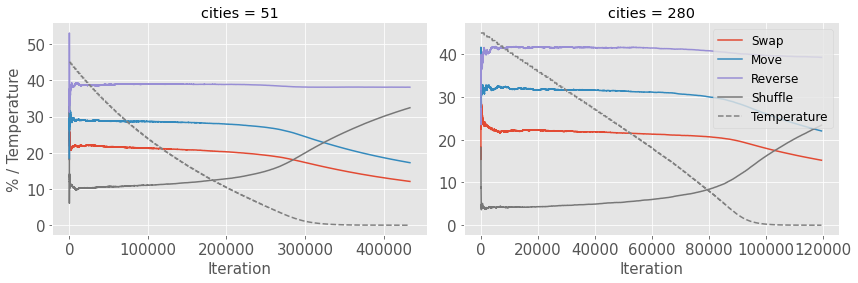

In [ ]:
# extract minimal value for each chain lenght and simulation
plt.figure(figsize=(14,7))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
for_plot = melted[melted.progress > 10]

g = sns.FacetGrid(for_plot, col = "cities", sharey=False, sharex=False, hue = "variable", height=4, aspect=1.5)
g.map(sns.lineplot, "progress", "value", ci = None)
g.set_axis_labels("Iteration", "% / Temperature")
for ax, city in zip(g.axes.flat, [51, 280]):
    ax.plot(cumsum_data[cumsum_data.cities == city].temp, label = "Temperature", color = "grey", linestyle = '--')
    ax.set_title(ax.get_title(), fontsize='x-large')
    # This only works for the left ylabels
    ax.set_ylabel(ax.get_ylabel(), fontsize=15)
    ax.set_xlabel(ax.get_xlabel(), fontsize=15)
    plt.legend(fontsize='large', title_fontsize='40', loc = "upper right")
plt.savefig(path_figures+"/mutation_method_change_updated2.pdf", bpi = 3000)

## Temperature plots

In [ ]:
df_file, dist_mat = read_tsp("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/a280.tsp.txt")

In [ ]:
## running simulated annealing, for adaptive
stop_criteria = 1000
chain_lenghts = [10, 100, 500, 2000]
path_280 = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/280/Temperature/"

for chain in chain_lenghts:
  random_route = [int(x) for x in random.sample(df_file.index.tolist(), k = len(df_file.index))]
  found_distances, all_distances, t_list, methods, best_route = SA(swap_nodes, random_route, dist_mat, chain = chain, alpha = 0.99, t_0 = 45, t_end = np.inf, stop_criteria=stop_criteria, sch_method="adaptive", adaptive=True)
  df_dict = {
      "order": range(stop_criteria+1),
      "Chain length": chain,
      "T": t_list
  }
  df = pd.DataFrame(df_dict)
  df.to_csv(f"{path_280}chain {chain}, mode: adaptive temperature.csv")


In [ ]:
## extract data for geometric and linear
stop_criteria = 1000
random_route = [int(x) for x in random.sample(df_file.index.tolist(), k = len(df_file.index))]
found_distances, all_distances, t_list_linear, methods, best_route = SA(swap_nodes, random_route, dist_mat, chain = 1, alpha = 0.99, t_0 = 45, t_end = np.inf, stop_criteria=stop_criteria, sch_method="linear", adaptive=True)
found_distances, all_distances, t_list_geometric, methods, best_route = SA(swap_nodes, random_route, dist_mat, chain = 1, alpha = 0.99, t_0 = 45, t_end = np.inf, stop_criteria=stop_criteria, sch_method="geometric", adaptive=True)

In [ ]:
# read in data
data_temperature = read_files_dir("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/280/Temperature/")
data_temperature.head()
data_temperature["Chain length"] = data_temperature["Chain length"].astype(str)
data_temperature["Chain length"] = data_temperature["Chain length"] + "-adaptive"
data_temperature.head()

In [ ]:
# plot temperature progression
plt.figure(figsize=(14,7))
sns.lineplot(data = data_temperature,
             x = "order",
             y = "T",
             hue = "Chain length",
             palette = "Set2")
plt.plot(t_list_linear, label = "linear", c = "r")
plt.plot(t_list_geometric, label = "geometric", c = "b")
plt.legend(loc = "best", fontsize='xx-large')
plt.ylabel("Temperature", size = text_size)
plt.xlabel("Iteration", size = text_size)
plt.savefig(path_figures+"/temperature_plot.pdf", bpi = 3000)

# Solving the 442 cities problem

In [ ]:
df_file, dist_mat = read_tsp("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/pcb442.tsp.txt")
df_file_51, dist_mat_51 = read_tsp("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/eil51.tsp.txt")
df_file_280, dist_mat_280 = read_tsp("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/a280.tsp.txt")

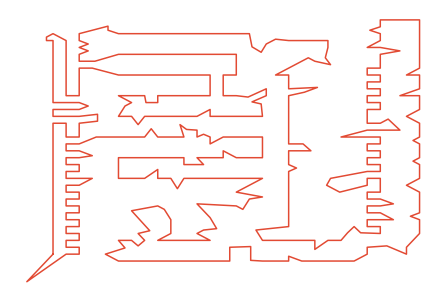

In [ ]:
# optimal solution
optimal_442 = read_optimal_route("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/pcb442.opt.tour.txt")
optimal_51 = read_optimal_route("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/eil51.opt.tour.txt")
optimal_280 = read_optimal_route("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/a280.opt.tour.txt")

plot_path(optimal_442, df_file)
plt.savefig(path_figures+"/optimal442.pdf", bpi = 3000)


In [ ]:
## running simulated annealing
stop_criteria = 2000
sims = 5
path_442 = "/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/442/"

for sim in range(sims):
  random_route = [int(x) for x in random.sample(df_file.index.tolist(), k = len(df_file.index))]
  found_distances, all_distances, t_list, methods, best_route = SA(swap_nodes, random_route, dist_mat, chain = 1000, alpha = 0.99, t_0 = 45, t_end = 0.0000000001, stop_criteria=stop_criteria, sch_method="adaptive", adaptive=True)
  df = pd.DataFrame(best_route)
  df.to_csv(f"{path_442}best route {sim}, distance: {get_distance(dist_mat, best_route)}.csv")


In [ ]:
best_route = pd.read_csv("/drive/My Drive/UvA/Stochastic Simulations/Assignment 3/Simulations/442/best route 1, distance: 51634.70328912011.csv")
best_route = best_route["0"].tolist()

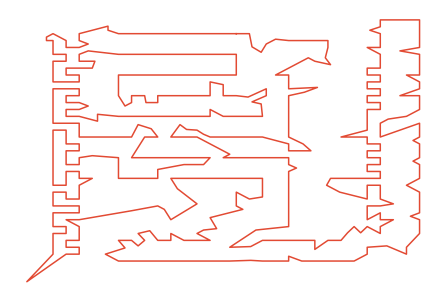

In [ ]:
plot_path(best_route, df_file)
plt.savefig(path_figures+"/our442.pdf", bpi = 3000)


In [ ]:
get_distance(dist_mat, best_route)

51634.70328912011

In [ ]:
get_distance(dist_mat_280, optimal_280)

2586.7696475631606